**Team 21**

Praanshu Patel (23110249)

Rishank Soni (23110277)

Repository link: https://github.com/Praanshu101/Model_Checkpointing

Open in colab:
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Praanshu101/Model_Checkpointing/blob/main/Model_Checkpointing.ipynb)

In [44]:
import warnings
warnings.filterwarnings("ignore")

## 1: Dataset Preparation

#### Getting files

In [45]:
import os

# Importing files
if os.path.exists("train.tsv"):
    print("File exists")
else:
    !wget https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/train.tsv

if os.path.exists("test.tsv"):
    print("File exists")
else:
    !wget https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/test.tsv

if os.path.exists("IMDB-Dataset.csv"):
    print("File exists")
else:
    !wget https://raw.githubusercontent.com/Ankit152/IMDB-sentiment-analysis/master/IMDB-Dataset.csv


File exists
File exists
File exists


##### Loading Dataset 1 (tsv files)

In [46]:
# Loading the datasets
import pandas as pd
import numpy as np

def extractfiles(file):
    df = pd.read_csv(file, sep='\t', header=None)
    df.columns = ['text', 'label']

    # Extracting text
    df['text'] = df['text'].astype(str).apply(lambda x: x.replace('\t', ''))

    # Extracting labels
    df['label'] = df['label'].astype(str).apply(lambda x: x.replace('\n', ''))
    df['label'] = df['label'].astype(int)

    # Printing counts to ensure no imbalance of classes
    print("Counts of each label:")
    print(df['label'].value_counts())

    df.head(10)

    return df

traindf = extractfiles("train.tsv")
test = extractfiles("test.tsv")

Counts of each label:
label
1    3610
0    3310
Name: count, dtype: int64
Counts of each label:
label
0    912
1    909
Name: count, dtype: int64


##### Splitting train data (from Dataset 1) into train and validation

In [47]:
# Split the dataset 1 into train and validation
from sklearn.model_selection import train_test_split

train, val = train_test_split(traindf, test_size=0.2, random_state=11)
print(f"Train shape: {train.shape}, Validation shape: {val.shape}")

train.head()

Train shape: (5536, 2), Validation shape: (1384, 2)


,text,label
1934,"for those in search of something different , w...",1
3425,"yes , mibii is rote work and predictable , but...",1
6025,this is an insultingly inept and artificial ex...,0
6478,"plunges you into a reality that is , more ofte...",1
1084,the problem with the mayhem in formula 51 is n...,0


##### Loading Dataset 2 (IMDB)

In [48]:
# Load IMDB dataset
imdb = pd.read_csv("IMDB-Dataset.csv")
imdb = imdb.rename(columns={"review": "text", "sentiment": "label"})
imdb['label'] = imdb['label'].apply(lambda x: 1 if x == 'positive' else 0)

# Printing counts to ensure no imbalance of classes
print("Counts of each label:")
print(imdb['label'].value_counts())

Counts of each label:
label
1    25000
0    25000
Name: count, dtype: int64


##### Splitting Dataset 2 into train and validation

In [49]:
# Train and validation split for IMDB dataset
imdb_train, imdb_val = train_test_split(imdb, test_size=0.2, random_state=11)
print(f"IMDB Train shape: {imdb_train.shape}, IMDB Validation shape: {imdb_val.shape}")

imdb_train.head()

IMDB Train shape: (40000, 2), IMDB Validation shape: (10000, 2)


,text,label
10024,Painful. Painful is the only word to describe ...,0
11762,This is a cute little French silent comedy abo...,1
43345,I loved this show when it aired on television ...,1
33685,It pains me to write such a scathing review bu...,0
23647,"""Stairway to Heaven"" is a outstanding inventio...",1


## 2: Model Construction

##### Model Architecture:

In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Model architecture
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(10000, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 2)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(F.relu(self.fc4(x)))
        return x

##### Model Parameters:

In [51]:
# Instantiate model
model = NeuralNetwork()

# Print summary
from torchsummary import summary
#summary(model, (1, 10000)) # 1 is the batch size and 10000 is the input size

In [52]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 5293122


## 3: Bag-of-words

In [53]:
from sklearn.feature_extraction.text import CountVectorizer

def bag_of_words(train_texts, val_texts, test_texts, max_features=10000):
    """
    Convert text data into Bag-of-Words features.

    Parameters:
    - train_texts: list or pandas Series of training texts
    - val_texts: list or pandas Series of validation texts
    - test_texts: list or pandas Series of test texts
    - max_features: maximum number of features for CountVectorizer

    Returns:
    - train_features: numpy array of training features
    - val_features: numpy array of validation features
    - test_features: numpy array of test features
    - vectorizer: fitted CountVectorizer instance
    """
    # Instantiate CountVectorizer
    vectorizer = CountVectorizer(max_features=max_features)

    # Fit and transform the training data
    train_features = vectorizer.fit_transform(train_texts)
    train_features = train_features.toarray()

    # Transform the validation data
    val_features = vectorizer.transform(val_texts)
    val_features = val_features.toarray()

    # Transform the test data
    test_features = vectorizer.transform(test_texts)
    test_features = test_features.toarray()

    # Print the shapes (number of samples, number of features)
    print(f"Train features shape: {train_features.shape}")
    print(f"Validation features shape: {val_features.shape}")
    print(f"Test features shape: {test_features.shape}")

    # Print length of vocab
    print(f"Length of vocab: {len(vectorizer.vocabulary_)}")

    # Print feature names
    print("Feature names:")
    print(vectorizer.get_feature_names_out()[:5])

    return train_features, val_features, test_features, vectorizer

# Dataset 1
train_features, val_features, test_features, vectorizer = bag_of_words(train['text'], val['text'], test['text'])

# Dataset 2
imdb_train_features, imdb_val_features, _, _ = bag_of_words(imdb_train['text'], imdb_val['text'], test['text'])

Train features shape: (5536, 10000)
Validation features shape: (1384, 10000)
Test features shape: (1821, 10000)
Length of vocab: 10000
Feature names:
['000' '10' '100' '101' '103']
Train features shape: (40000, 10000)
Validation features shape: (10000, 10000)
Test features shape: (1821, 10000)
Length of vocab: 10000
Feature names:
['00' '000' '007' '10' '100']


##### Converting arrays to tensors

In [54]:
def convert_to_tensors(train_features, val_features, test_features, train_labels, val_labels, test_labels):
    # Convert the features to tensors
    train_features = torch.tensor(train_features, dtype=torch.float32)
    val_features = torch.tensor(val_features, dtype=torch.float32)
    test_features = torch.tensor(test_features, dtype=torch.float32)

    # Convert the labels to tensors
    train_labels = torch.tensor(train_labels, dtype=torch.int64)
    val_labels = torch.tensor(val_labels, dtype=torch.int64)
    test_labels = torch.tensor(test_labels, dtype=torch.int64)

    # Print the shapes
    print(f"Train features shape: {train_features.shape}, Train labels shape: {train_labels.shape}")
    print(f"Validation features shape: {val_features.shape}, Validation labels shape: {val_labels.shape}")
    print(f"Test features shape: {test_features.shape}, Test labels shape: {test_labels.shape}")

    return train_features, val_features, test_features, train_labels, val_labels, test_labels

# Dataset 1
train_features, val_features, test_features, train_labels, val_labels, test_labels = convert_to_tensors(
    train_features, val_features, test_features, train['label'].values, val['label'].values, test['label'].values)

# Dataset 2
imdb_train_features, imdb_val_features, _, imdb_train_labels, imdb_val_labels, _ = convert_to_tensors(
    imdb_train_features, imdb_val_features, test_features, imdb_train['label'].values, imdb_val['label'].values, test['label'].values)

Train features shape: torch.Size([5536, 10000]), Train labels shape: torch.Size([5536])
Validation features shape: torch.Size([1384, 10000]), Validation labels shape: torch.Size([1384])
Test features shape: torch.Size([1821, 10000]), Test labels shape: torch.Size([1821])
Train features shape: torch.Size([40000, 10000]), Train labels shape: torch.Size([40000])
Validation features shape: torch.Size([10000, 10000]), Validation labels shape: torch.Size([10000])
Test features shape: torch.Size([1821, 10000]), Test labels shape: torch.Size([1821])


## 4: Constructing a function to use bert-base-uncased embeddings on the same model

In [55]:
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModel

# Determine the appropriate device
if torch.cuda.is_available():
    device = "cuda"
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"  # Mac M1/M2 GPU
else:
    device = "cpu"
print(f"Using device: {device}")

# Specify the model name for bert-base-uncased
model_name = "bert-base-uncased"

class BertEmbedder:
    def __init__(self, model_name=model_name, device=device):
        self.device = device
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

        # Use FP16 if CUDA is available, else default to FP32 for CPU or MPS
        dtype = torch.float16 if device == "cuda" else torch.float32
        self.model = AutoModel.from_pretrained(model_name, torch_dtype=dtype).to(self.device)

        self.embedding_size = self.model.config.hidden_size
        self.model_loaded = True

    def get_embeddings(self, texts, batch_size=16):
        print(f"Embedding on device: {self.device}")
        embeddings_list = []
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i + batch_size]
            tokens = self.tokenizer(
                batch,
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=512
            ).to(self.device)

            with torch.no_grad():
                outputs = self.model(**tokens)

            # Use attention mask to perform weighted mean pooling over token embeddings
            input_mask = tokens["attention_mask"].unsqueeze(-1)  # Shape: [batch_size, seq_length, 1]
            sum_embeddings = (outputs.last_hidden_state * input_mask).sum(dim=1)
            sum_mask = input_mask.sum(dim=1)
            embeddings = sum_embeddings / sum_mask

            embeddings_list.append(embeddings.cpu().numpy())
        return np.concatenate(embeddings_list, axis=0)

# Initialize the Bert embedder
embedder = BertEmbedder()

# Example usage: Generate embeddings for sample texts
sample_texts = ["Hello world!", "How are you today?"]
embeddings = embedder.get_embeddings(sample_texts)
print("Embeddings shape:", embeddings.shape)


Using device: cuda
Embedding on device: cuda
Embeddings shape: (2, 768)


In [56]:
# Make embeddings of size 768 for both datasets
train_embeddings = embedder.get_embeddings(train['text'].tolist())
val_embeddings = embedder.get_embeddings(val['text'].tolist())
test_embeddings = embedder.get_embeddings(test['text'].tolist())
imdb_train_embeddings = embedder.get_embeddings(imdb_train['text'].tolist())
imdb_val_embeddings = embedder.get_embeddings(imdb_val['text'].tolist())

Embedding on device: cuda
Embedding on device: cuda
Embedding on device: cuda
Embedding on device: cuda
Embedding on device: cuda


In [57]:
# Print shapes
print("Dataset 1:")
print(f"Train embeddings shape: {train_embeddings.shape}")
print(f"Validation embeddings shape: {val_embeddings.shape}")
print(f"Test embeddings shape: {test_embeddings.shape}")

print("\nDataset 2:")
print(f"IMDB Train embeddings shape: {imdb_train_embeddings.shape}")
print(f"IMDB Validation embeddings shape: {imdb_val_embeddings.shape}")

Dataset 1:
Train embeddings shape: (5536, 768)
Validation embeddings shape: (1384, 768)
Test embeddings shape: (1821, 768)

Dataset 2:
IMDB Train embeddings shape: (40000, 768)
IMDB Validation embeddings shape: (10000, 768)


## Train the model with 10 epochs and create the best-performing model (checkpoint.pt) on the Dataset 1. (Doing for both embeddings)

Function to plot curves

In [58]:
# Plot the training and validation loss curves
import matplotlib.pyplot as plt

def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.scatter(range(0, len(train_losses)), train_losses, label='Train loss', color='b')
    plt.plot(train_losses, label='Train loss', color='b')
    plt.scatter(range(0, len(val_losses)), val_losses, label='Validation loss', color='r')
    plt.plot(val_losses, label='Validation loss', color='r')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Training on BoW embeddings:

Train features shape: torch.Size([5536, 10000]), Train labels shape: torch.Size([5536])
Validation features shape: torch.Size([1384, 10000]), Validation labels shape: torch.Size([1384])
Test features shape: torch.Size([1821, 10000]), Test labels shape: torch.Size([1821])
Epoch 1/10, Train Loss: 0.5917, Val Loss: 0.4848, Val Acc: 0.7673
Epoch 2/10, Train Loss: 0.2562, Val Loss: 0.5220, Val Acc: 0.7695
Epoch 3/10, Train Loss: 0.0678, Val Loss: 0.8249, Val Acc: 0.7695
Epoch 4/10, Train Loss: 0.0141, Val Loss: 1.6077, Val Acc: 0.7623
Epoch 5/10, Train Loss: 0.0062, Val Loss: 1.9091, Val Acc: 0.7565
Epoch 6/10, Train Loss: 0.0059, Val Loss: 1.9398, Val Acc: 0.7630
Epoch 7/10, Train Loss: 0.0010, Val Loss: 2.4227, Val Acc: 0.7681
Epoch 8/10, Train Loss: 0.0008, Val Loss: 2.9282, Val Acc: 0.7594
Epoch 9/10, Train Loss: 0.0185, Val Loss: 1.7234, Val Acc: 0.7536
Epoch 10/10, Train Loss: 0.0093, Val Loss: 1.5658, Val Acc: 0.7579


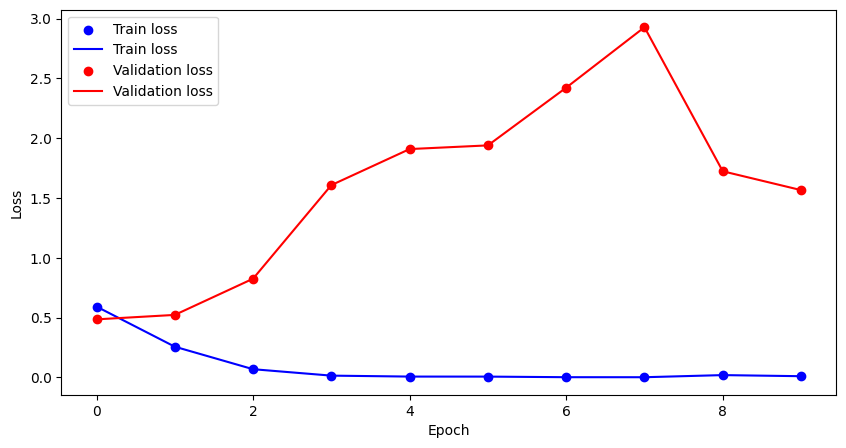

In [60]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
import datetime
import gzip

# Create TensorBoard writer with unique run name
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = f"runs/sentiment_model_{current_time}"
writer = SummaryWriter(log_dir)

# Instantiate the model
model = NeuralNetwork()

# Move model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the batch size
batch_size = 32

# Verify the shapes of the features and labels
print(f"Train features shape: {train_features.shape}, Train labels shape: {train_labels.shape}")
print(f"Validation features shape: {val_features.shape}, Validation labels shape: {val_labels.shape}")
print(f"Test features shape: {test_features.shape}, Test labels shape: {test_labels.shape}")

# Create Tensor datasets
train_dataset = TensorDataset(train_features, train_labels)
val_dataset = TensorDataset(val_features, val_labels)
test_dataset = TensorDataset(test_features, test_labels)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Add model graph to TensorBoard (use a sample from your data)
# Get a sample input for the model graph
sample_inputs, _ = next(iter(train_loader))
writer.add_graph(model, sample_inputs.to(device).float())

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the number of epochs
n_epochs = 10
best_val_loss = float('inf')  # Track the best validation loss

trainloss = []
valloss = []

# Training loop with TensorBoard
for epoch in range(n_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        # Move data to device
        inputs, labels = inputs.to(device).float(), labels.to(device).long()

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass & optimization
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        
        # Log batch-level metrics (optional - for more detailed tracking)
        if batch_idx % 10 == 0:  # Log every 10 batches
            writer.add_scalar('Batch/Loss', loss.item(), epoch * len(train_loader) + batch_idx)

    train_loss /= len(train_loader)  # Average training loss
    train_accuracy = train_correct / train_total

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device).float(), labels.to(device).long()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Accuracy calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_loader)
    val_accuracy = correct / total

    trainloss.append(train_loss)
    valloss.append(val_loss)
    
    # Log epoch-level metrics to TensorBoard
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/validation', val_loss, epoch)
    writer.add_scalar('Accuracy/train', train_accuracy, epoch)
    writer.add_scalar('Accuracy/validation', val_accuracy, epoch)
    
    # Log model parameter histograms
    for name, param in model.named_parameters():
        writer.add_histogram(f'Parameters/{name}', param, epoch)

    # Save the best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        checkpoint = {
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch,
            'best_val_loss': best_val_loss
        }
        # Using gzip to compress the checkpoint file
        with gzip.open("checkpoint.pt.gz", "wb") as f:
            torch.save(checkpoint, f)
        
        writer.add_text('Checkpoint', f'New best model saved at epoch {epoch+1} with validation loss: {val_loss:.4f}', epoch)

    # Print epoch results
    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

# Close TensorBoard writer
writer.close()

# Plot using your existing function
plot_loss(trainloss, valloss)

Training on BERT embeddings:

In [62]:
# Training on BERT embeddings with TensorBoard
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
import datetime
import gzip
# Add this code before your TensorBoard setup to create the embeddings

# 1. Load and split data from TSV files
def load_tsv_dataset(file_path):
    df = pd.read_csv(file_path, sep='\t', header=None)
    df.columns = ['text', 'label']
    # Convert labels to integers if needed
    df['label'] = df['label'].astype(int)
    return df

# Load train and test data
train_df = load_tsv_dataset("train.tsv")
test_df = load_tsv_dataset("test.tsv")

# Split train into train and validation
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")

# 2. Generate embeddings using BERT
print("Generating train embeddings...")
train_embeddings = embedder.get_embeddings(train_df['text'].tolist())
train_labels = torch.tensor(train_df['label'].values)

print("Generating validation embeddings...")
val_embeddings = embedder.get_embeddings(val_df['text'].tolist())
val_labels = torch.tensor(val_df['label'].values)

print("Generating test embeddings...")
test_embeddings = embedder.get_embeddings(test_df['text'].tolist())
test_labels = torch.tensor(test_df['label'].values)


# Create a TensorBoard writer
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = f"runs/bert_model_{current_time}"
writer = SummaryWriter(log_dir)

# Model architecture
class NeuralNetwork2(nn.Module):
    def __init__(self):
        super(NeuralNetwork2, self).__init__()
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 2)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(F.relu(self.fc4(x)))
        x = self.fc5(x)  # Fixed: Include final layer
        return x

# Instantiate the model
model2 = NeuralNetwork2()

# Move model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2.to(device)

# Define the batch size
batch_size = 32

# Verify the shapes of the features and labels
print(f"Train features shape: {train_embeddings.shape}, Train labels shape: {train_labels.shape}")
print(f"Validation features shape: {val_embeddings.shape}, Validation labels shape: {val_labels.shape}")
print(f"Test features shape: {test_embeddings.shape}, Test labels shape: {test_labels.shape}")

# Create Tensor datasets
train_dataset = TensorDataset(torch.tensor(train_embeddings), torch.tensor(train_labels))
val_dataset = TensorDataset(torch.tensor(val_embeddings), torch.tensor(val_labels))
test_dataset = TensorDataset(torch.tensor(test_embeddings), torch.tensor(test_labels))

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Add model graph to TensorBoard
sample_inputs, _ = next(iter(train_loader))
writer.add_graph(model2, sample_inputs.to(device).float())

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)

# Define the number of epochs
n_epochs = 10
best_val_loss = float('inf')  # Track the best validation loss

trainloss = []
valloss = []

# Training loop with TensorBoard logging
for epoch in range(n_epochs):
    model2.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        # Move data to device
        inputs, labels = inputs.to(device).float(), labels.to(device).long()

        # Zero the gradients
        optimizer2.zero_grad()

        # Forward pass
        outputs = model2(inputs)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass & optimization
        loss.backward()
        optimizer2.step()

        train_loss += loss.item()
        
        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        # Log batch-level metrics (every 10 batches)
        if batch_idx % 10 == 0:
            step = epoch * len(train_loader) + batch_idx
            writer.add_scalar('Batch/Loss', loss.item(), step)

    train_loss /= len(train_loader)  # Average training loss
    train_accuracy = train_correct / train_total

    # Validation phase
    model2.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device).float(), labels.to(device).long()

            # Forward pass
            outputs = model2(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Accuracy calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_loader)
    val_accuracy = correct / total

    trainloss.append(train_loss)
    valloss.append(val_loss)
    
    # Log epoch-level metrics to TensorBoard
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/validation', val_loss, epoch)
    writer.add_scalar('Accuracy/train', train_accuracy, epoch)
    writer.add_scalar('Accuracy/validation', val_accuracy, epoch)
    
    # Log model parameter histograms
    for name, param in model2.named_parameters():
        writer.add_histogram(f'Parameters/{name}', param, epoch)

    # Save the best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        checkpoint = {
            'model_state_dict': model2.state_dict(),
            'optimizer_state_dict': optimizer2.state_dict(),
            'epoch': epoch,
            'best_val_loss': best_val_loss
        }
        # Using gzip to compress the checkpoint file
        with gzip.open("bert_checkpoint.pt.gz", "wb") as f:
            torch.save(checkpoint, f)
        
        writer.add_text('Checkpoint', f'New best model saved at epoch {epoch+1} with validation loss: {val_loss:.4f}', epoch)

    # Print epoch results
    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

# Close the TensorBoard writer
writer.close()

plot_loss(trainloss, valloss)

Train size: 5536, Validation size: 1384, Test size: 1821
Generating train embeddings...
Generating embeddings on mps with batch size 32
Processed batch 10/173 in 15.63 seconds
Processed batch 20/173 in 16.89 seconds
Processed batch 30/173 in 18.07 seconds
Processed batch 40/173 in 18.94 seconds
Processed batch 50/173 in 25.28 seconds
Processed batch 60/173 in 26.30 seconds


KeyboardInterrupt: 

## Using the checkpoint from before and train on the IMDB dataset (Dataset 2).

Loading the checkpoint for BoW embeddings:

In [67]:
# Load the best model
#model.load_state_dict(torch.load('checkpoint.pt'))

# Gzip
with gzip.open("checkpoint.pt.gz", "rb") as f:
    checkpoint = torch.load(f, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

Training on BoW embeddings:

Epoch 1/5, Train Loss: 4.6974, Train Acc: 0.5607, Val Loss: 0.6655, Val Acc: 0.5938
Epoch 2/5, Train Loss: 0.6570, Train Acc: 0.6188, Val Loss: 0.5864, Val Acc: 0.7063
Epoch 3/5, Train Loss: 0.4933, Train Acc: 0.7731, Val Loss: 0.3619, Val Acc: 0.8496
Epoch 4/5, Train Loss: 0.3243, Train Acc: 0.8726, Val Loss: 0.2759, Val Acc: 0.8931
Epoch 5/5, Train Loss: 0.2443, Train Acc: 0.9042, Val Loss: 0.2621, Val Acc: 0.8987


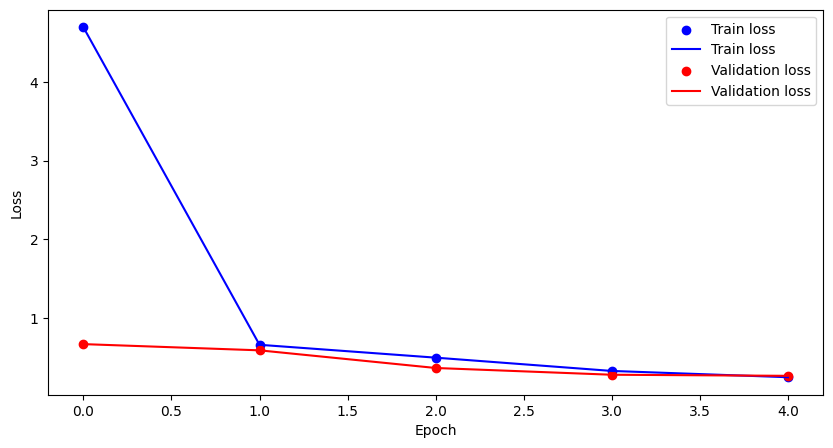

In [63]:
# Use the checkpoint from before and train on the IMDB dataset (Dataset 2)
from torch.utils.tensorboard import SummaryWriter
import datetime

# Create a TensorBoard writer for this fine-tuning experiment
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = f"runs/imdb_finetuning_{current_time}"
writer = SummaryWriter(log_dir)

# Create Tensor datasets
imdb_train_dataset = TensorDataset(imdb_train_features, imdb_train_labels)
imdb_val_dataset = TensorDataset(imdb_val_features, imdb_val_labels)

# Create DataLoaders
imdb_train_loader = DataLoader(imdb_train_dataset, batch_size=batch_size, shuffle=True)
imdb_val_loader = DataLoader(imdb_val_dataset, batch_size=batch_size, shuffle=False)

n_epochs = 5
best_val_loss = float('inf')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Lower learning rate

trainloss = []
valloss = []

# Log model architecture to TensorBoard
sample_inputs, _ = next(iter(imdb_train_loader))
writer.add_graph(model, sample_inputs.to(device).float())

# Log hyperparameters
writer.add_text('Hyperparameters', 
                f'Learning Rate: {0.0001}\n'
                f'Batch Size: {batch_size}\n'
                f'Epochs: {n_epochs}\n'
                f'Optimizer: Adam\n'
                f'Model: Fine-tuning from checkpoint on IMDB dataset', 0)

# Training loop with TensorBoard
for epoch in range(n_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training phase with batch-level logging
    for batch_idx, (inputs, labels) in enumerate(imdb_train_loader):
        # Move data to device
        inputs, labels = inputs.to(device).float(), labels.to(device).long()

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass & optimization
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        
        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
        # Log batch-level metrics (every 20 batches)
        if batch_idx % 20 == 0:
            step = epoch * len(imdb_train_loader) + batch_idx
            writer.add_scalar('Batch/Loss', loss.item(), step)

    # Calculate epoch training metrics
    train_loss /= len(imdb_train_loader)
    train_accuracy = correct_train / total_train
    trainloss.append(train_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in imdb_val_loader:
            inputs, labels = inputs.to(device).float(), labels.to(device).long()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Accuracy calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(imdb_val_loader)
    val_accuracy = correct / total
    valloss.append(val_loss)

    # Log epoch-level metrics to TensorBoard
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/validation', val_loss, epoch)
    writer.add_scalar('Accuracy/train', train_accuracy, epoch)
    writer.add_scalar('Accuracy/validation', val_accuracy, epoch)
    
    # Log histograms of model parameters
    for name, param in model.named_parameters():
        writer.add_histogram(f'Parameters/{name}', param, epoch)

    # Save the best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        checkpoint = {
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch,
            'best_val_loss': best_val_loss
        }
        # Using gzip to compress the checkpoint file
        with gzip.open("checkpoint_imdb.pt.gz", "wb") as f:
            torch.save(checkpoint, f)
            
        # Log checkpoint info to TensorBoard
        writer.add_text('Checkpoint', 
                       f'New best model saved at epoch {epoch+1} with validation loss: {val_loss:.4f}', 
                       epoch)

    # Print epoch results
    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

# Close the TensorBoard writer
writer.close()

# Plot loss curves using your existing function
plot_loss(trainloss, valloss)

Loading the checkpoint for BERT embeddings:

In [69]:
# Load bert checkpoint
with gzip.open("bert_checkpoint.pt.gz", "rb") as f:
    checkpoint = torch.load(f, map_location=torch.device('cpu'))
model2.load_state_dict(checkpoint['model_state_dict'])
optimizer2.load_state_dict(checkpoint['optimizer_state_dict'])

Training on BERT embeddings:

In [65]:
# Use the checkpoint from before and train on the IMDB dataset (Dataset 2)

# Create Tensor datasets
imdb_train_dataset = TensorDataset(torch.tensor(imdb_train_embeddings), imdb_train_labels)
imdb_val_dataset = TensorDataset(torch.tensor(imdb_val_embeddings), imdb_val_labels)

# Create DataLoaders
imdb_train_loader = DataLoader(imdb_train_dataset, batch_size=batch_size, shuffle=True)
imdb_val_loader = DataLoader(imdb_val_dataset, batch_size=batch_size, shuffle=False)

n_epochs = 5
best_val_loss = float('inf')
criterion = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(model2.parameters(), lr=0.0001) # Lower learning rate

trainloss=[]
valloss=[]

# Training loop
for epoch in range(n_epochs):
    model2.train()
    train_loss = 0.0

    for inputs, labels in imdb_train_loader:
        # Move data to device
        inputs, labels = inputs.to(device).float(), labels.to(device).long()

        # Zero the gradients
        optimizer2.zero_grad()

        # Forward pass
        outputs = model2(inputs)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass & optimization
        loss.backward()
        optimizer2.step()

        train_loss += loss.item()

    train_loss /= len(imdb_train_loader)  # Average training loss

    # Validation phase
    model2.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in imdb_val_loader:
            inputs, labels = inputs.to(device).float(), labels.to(device).long()

            # Forward pass
            outputs = model2(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Accuracy calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(imdb_val_loader)
    val_accuracy = correct / total

    trainloss.append(train_loss)
    valloss.append(val_loss)

    # Save the best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        #torch.save(model.state_dict(), 'checkpoint_imdb.pt')
        checkpoint = {
            'model_state_dict': model2.state_dict(),
            'optimizer_state_dict': optimizer2.state_dict(),
            'epoch': epoch,
            'best_val_loss': best_val_loss
        }
        # Using gzip to compress the checkpoint file
        with gzip.open("bert_checkpoint_imdb.pt.gz", "wb") as f:
            torch.save(checkpoint, f)

    # Print epoch results
    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

plot_loss(trainloss, valloss)

NameError: name 'imdb_train_embeddings' is not defined

Evaluating on test data

In [80]:
# Load the BoW checkpoint
with gzip.open("checkpoint_imdb.pt.gz", "rb") as f:
    checkpoint = torch.load(f, map_location=torch.device('cpu'))

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

Accuracy: 0.7309


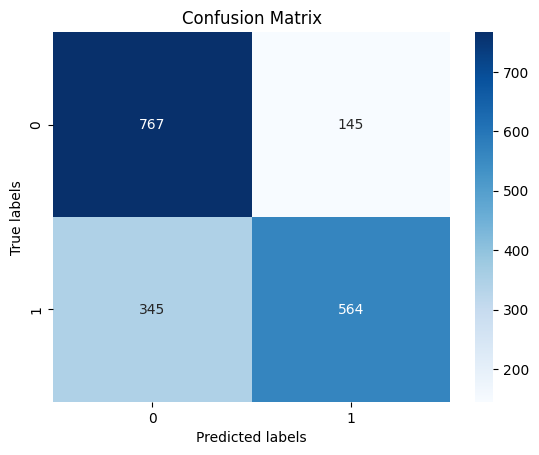

In [82]:
# Evaluate the model on the test set
from sklearn.metrics import confusion_matrix
from seaborn import heatmap
import matplotlib.pyplot as plt


test_dataset = TensorDataset(test_features, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device).float(), labels.to(device).long()

        # Forward pass
        outputs = model(inputs)

        # Accuracy calculation
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Print the accuracy
accuracy = sum(np.array(y_true) == np.array(y_pred)) / len(y_true)
print(f"Accuracy: {accuracy:.4f}")

# Plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [77]:
# Load the bert checkpointt
with gzip.open("bert_checkpoint_imdb.pt.gz", "rb") as f:
    checkpoint = torch.load(f, map_location=torch.device('cpu'))

model2.load_state_dict(checkpoint['model_state_dict'])
optimizer2.load_state_dict(checkpoint['optimizer_state_dict'])

Accuracy: 0.7985


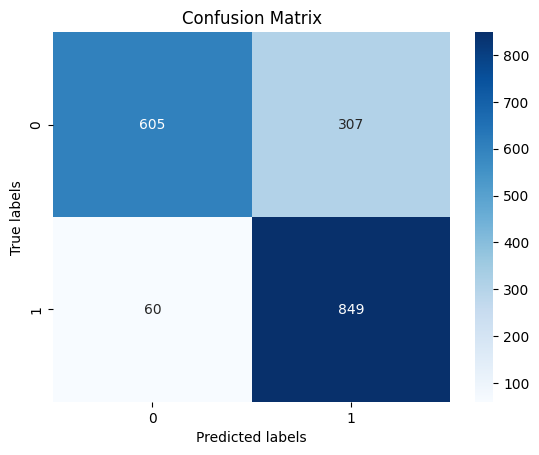

In [84]:
# Evaluate the model on the test set
from sklearn.metrics import confusion_matrix
from seaborn import heatmap
import matplotlib.pyplot as plt


test_dataset = TensorDataset(torch.tensor(test_embeddings), test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model2.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device).float(), labels.to(device).long()

        # Forward pass
        outputs = model2(inputs)

        # Accuracy calculation
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Print the accuracy
accuracy = sum(np.array(y_true) == np.array(y_pred)) / len(y_true)
print(f"Accuracy: {accuracy:.4f}")

# Plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()